In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import rankdata
from scipy.stats import norm
from geo_northarrow import add_north_arrow
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tabulate import tabulate
np.float = float 

In [2]:
# Load the dataset
# Read the GeoPackage file containing the catchment data
gdf = gpd.read_file("G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_MGWR/DATA/df_catchments_kmeans.gpkg")
gdf.info()  # Display basic information about the GeoDataFrame

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   526 non-null    int64   
 1   Nombre               526 non-null    object  
 2   ID_CUENCA            526 non-null    float64 
 3   cuenca               526 non-null    object  
 4   area                 526 non-null    int64   
 5   elev_mean            526 non-null    float64 
 6   elev_median          526 non-null    float64 
 7   rel_mean             526 non-null    float64 
 8   rel_median           526 non-null    float64 
 9   rainfallAnnual_mean  526 non-null    float64 
 10  Densidad             526 non-null    float64 
 11  hypso_inte           526 non-null    float64 
 12  slope_mean           526 non-null    float64 
 13  kmeans               526 non-null    object  
 14  RainfallDaysmean     526 non-null    float64 
 15  RainfallDaysmed

In [13]:
# Calculate landslide frequency as landslides per unit area
gdf['y_log'] = np.log(gdf['lands_rec'] + 1)
g_y = gdf['y_log'].values.reshape(-1, 1)

In [8]:
#definir coordenadas como puntos
u = gdf.centroid.x
v = gdf.centroid.y
g_coords = list(zip(u, v))

In [9]:
# Standardize continuous variables 'elev_mean' and 'slope_mean'
scaler = StandardScaler()
g_X_num = scaler.fit_transform(gdf[['elev_mean', 'rel_mean',"RainfallDaysmean"]])

## Modelo lineal estandar

In [13]:
# Updated data with consistent variable names and fields from the table
data = [
    ["Intercepto", "1.840", "0.054", "0.000"],
    ["Elevación", "0.537", "0.079", "0.000"],
    ["Relieve", "0.524", "0.065", "0.000"],
    ["Lluvia", "-0.047", "0.069", "0.493"],
    [""],
    ["Log-likelihood", "-858.936", "", ""],
    ["AIC", "1725.872", "", ""],
    ["Adj. R2", "0.371", "", ""]
]

# Headers for the table
headers = ["Variable", "Est.", "SE", "p-value"]

# Generate the LaTeX code using tabulate
latex_table = tabulate(data, headers=headers, tablefmt="latex", stralign="center")

# Print the generated LaTeX code
print(latex_table)


\begin{tabular}{crcc}
\hline
    Variable    &     Est. &  SE   &  p-value  \\
\hline
   Intercepto   &    1.84  & 0.054 &   0.000   \\
   Elevación    &    0.537 & 0.079 &   0.000   \\
    Relieve     &    0.524 & 0.065 &   0.000   \\
     Lluvia     &   -0.047 & 0.069 &   0.493   \\
                &          &       &           \\
 Log-likelihood & -858.936 &       &           \\
      AIC       & 1725.87  &       &           \\
    Adj. R2     &    0.371 &       &           \\
\hline
\end{tabular}


## Variables (distancia)

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            908.118
Log-likelihood:                                                    -889.979
AIC:                                                               1783.958
AICc:                                                              1786.004
BIC:                                                              -2374.899
R2:                                                                   0.296
Adj. R2:                                                              0.295

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

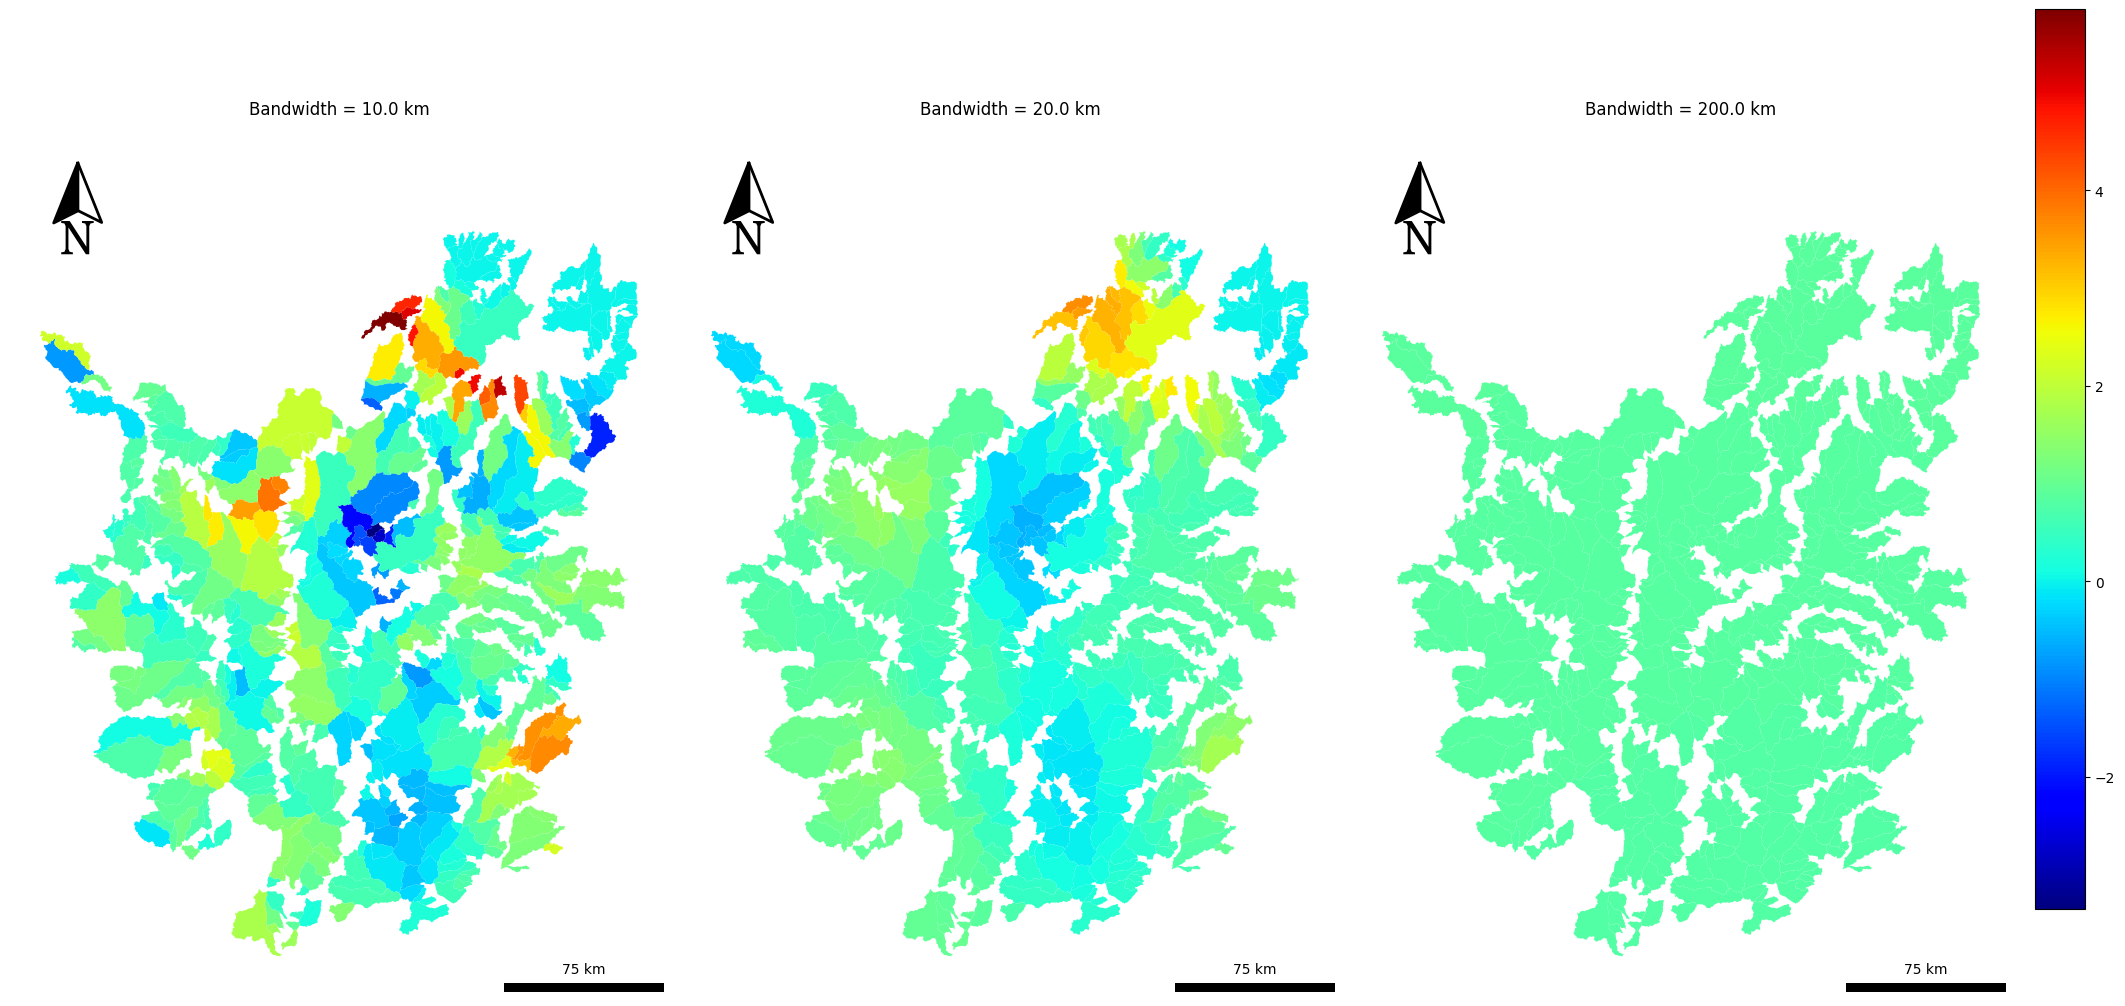

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            927.299
Log-likelihood:                                                    -895.476
AIC:                                                               1794.952
AICc:                                                              1796.998
BIC:                                                              -2355.718
R2:                                                                   0.281
Adj. R2:                                                              0.280

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

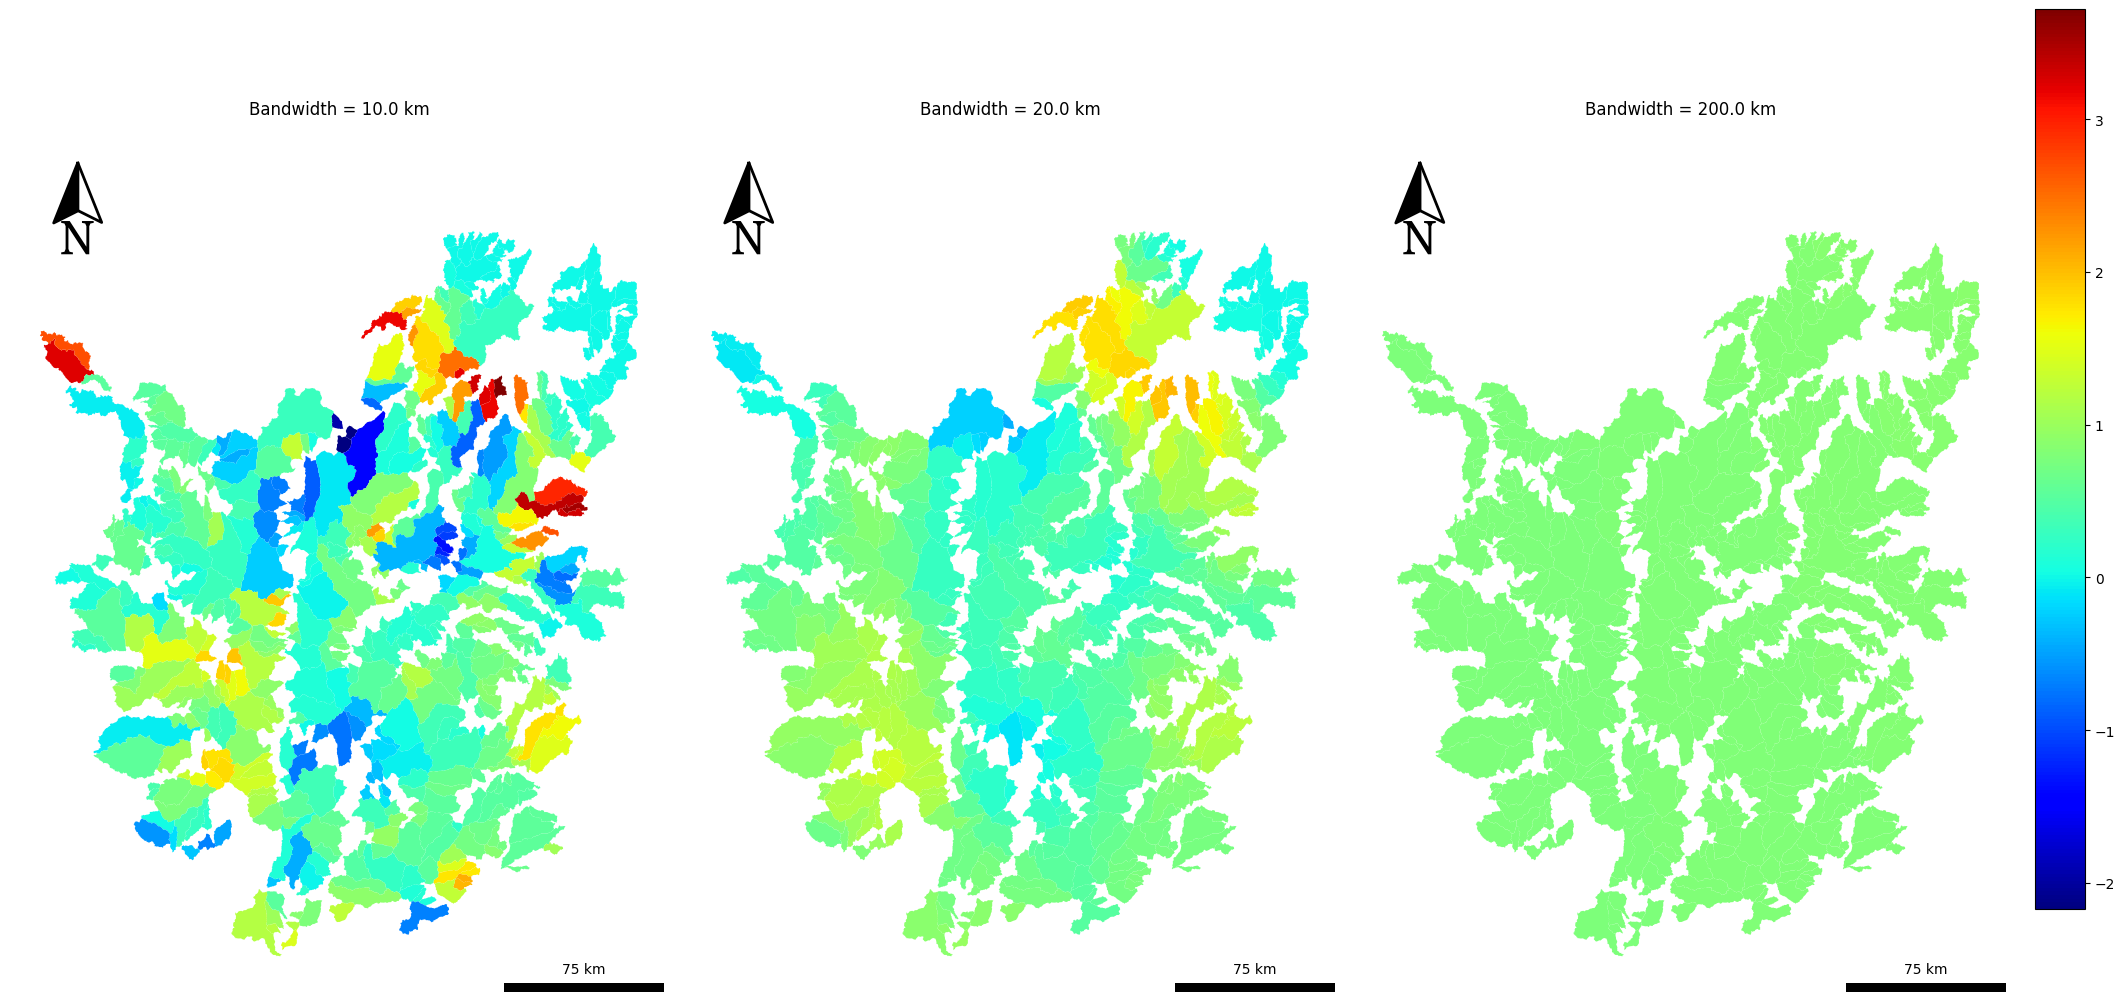

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1143.019
Log-likelihood:                                                    -950.483
AIC:                                                               1904.966
AICc:                                                              1907.012
BIC:                                                              -2139.999
R2:                                                                   0.114
Adj. R2:                                                              0.112

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

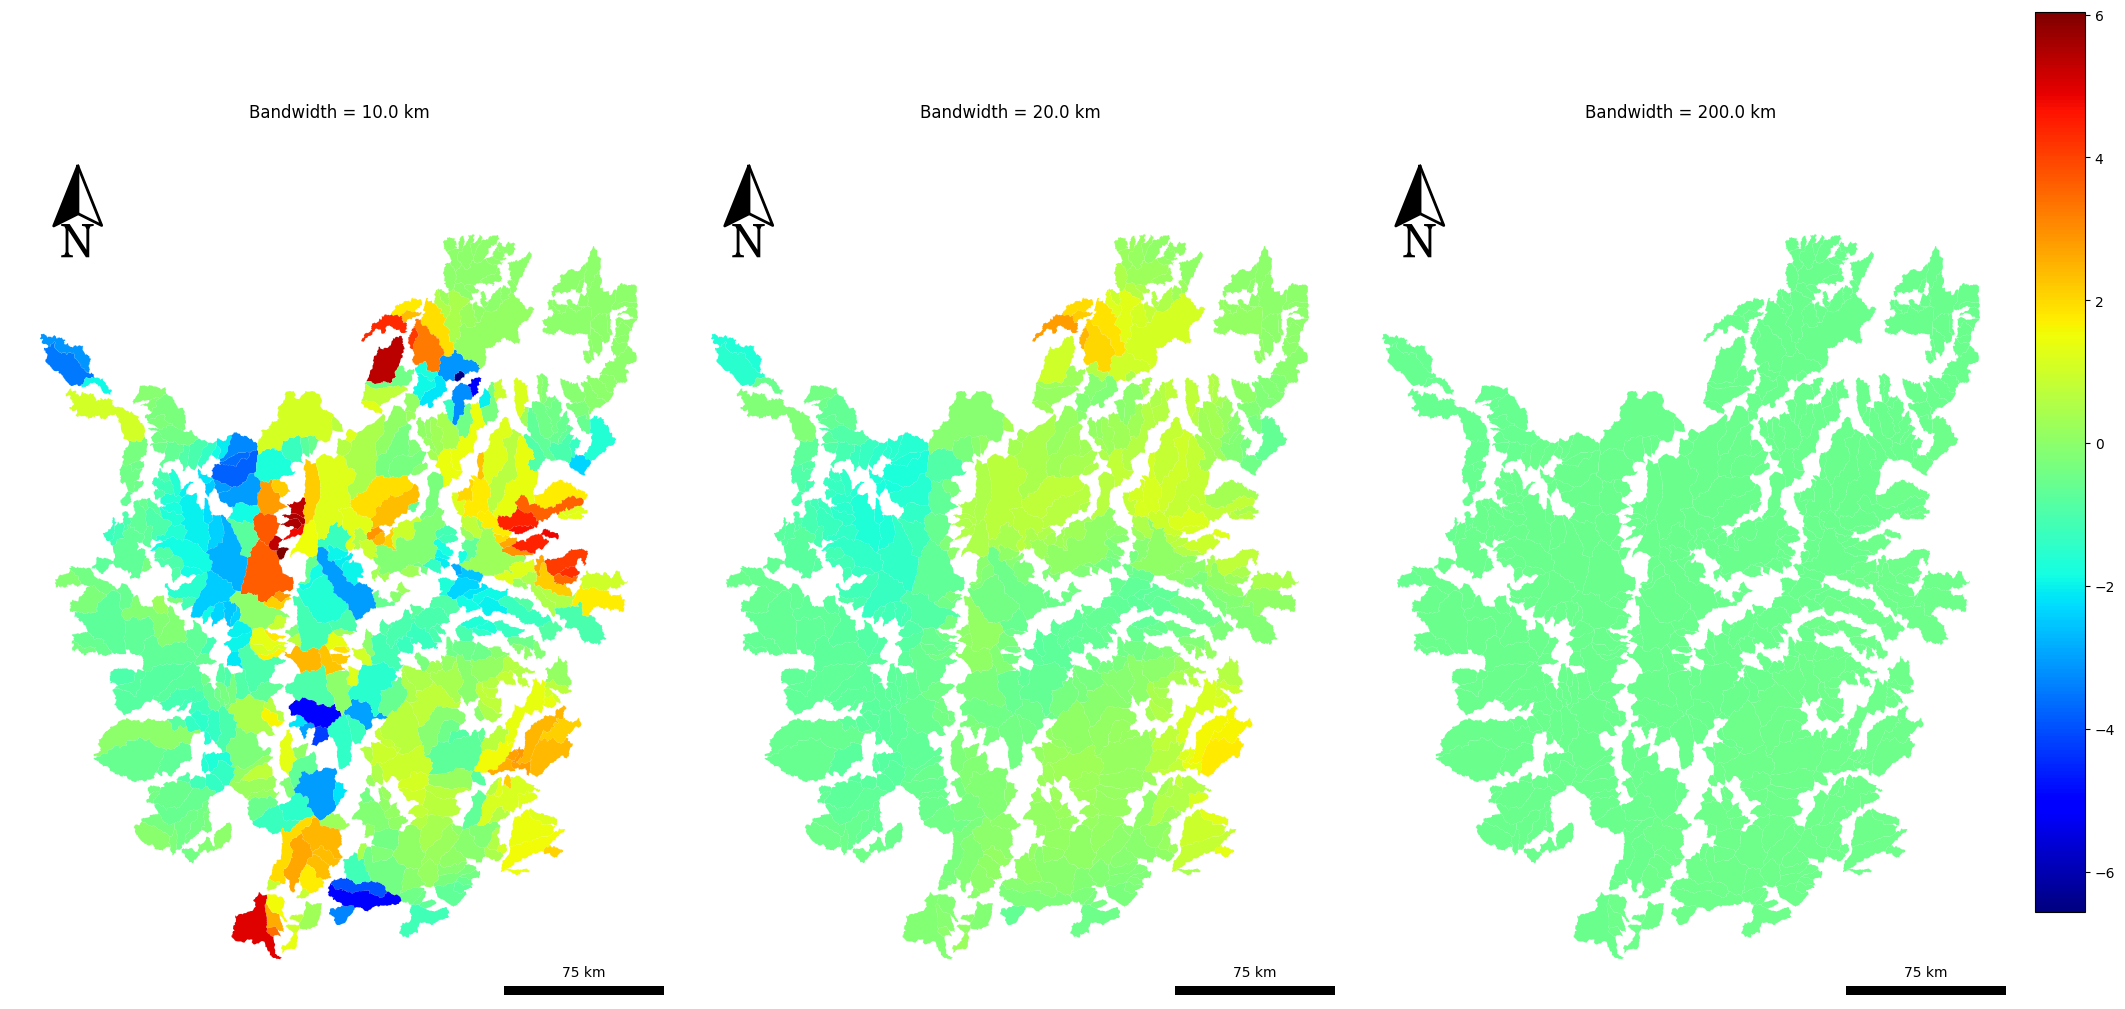

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1181.970
Log-likelihood:                                                    -959.296
AIC:                                                               1922.592
AICc:                                                              1924.638
BIC:                                                              -2101.048
R2:                                                                   0.084
Adj. R2:                                                              0.082

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

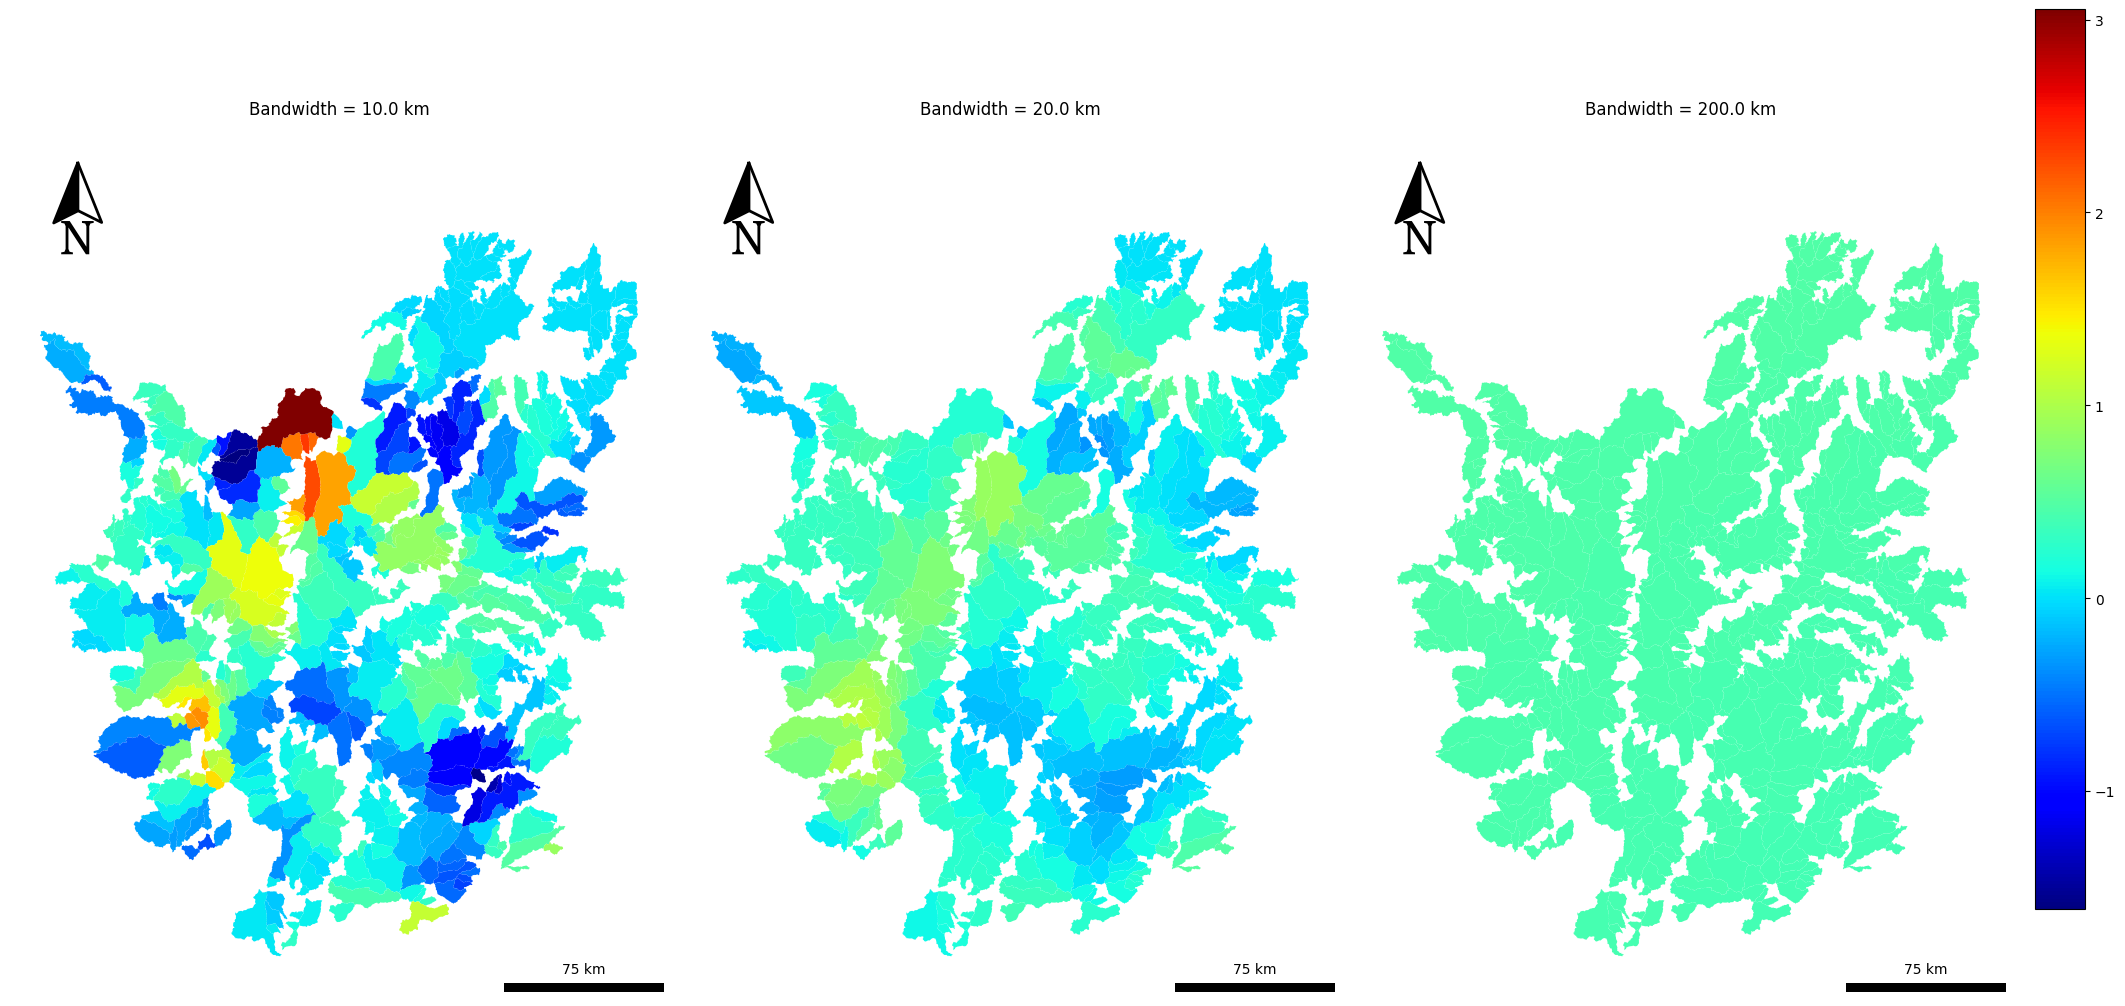

In [6]:
variables = ['elev_mean', 'rel_mean',"rainfallAnnual_mean",'hypso_inte']
for param_name in variables:
    g_X_num = scaler.fit_transform(gdf[[param_name]])
    bandwidths = [10000, 20000, 200000]
    
    # Determine the global min and max values for the color bar range across all bandwidths
    global_min = float('inf')
    global_max = float('-inf')
    
    # Loop to determine global min and max for colorbar
    for bw in bandwidths:
        # Fit GWR model using the current bandwidth
        model = GWR(g_coords, g_y, g_X_num, bw, kernel='gaussian',fixed=True).fit()
        model.summary()
    
        # Extract the local coefficients for the specified covariate
        local_params = model.params[:, 1]  # Index 1 for 'elev_mean' (skipping intercept)
        
        # Update global min and max
        global_min = min(global_min, local_params.min())
        global_max = max(global_max, local_params.max())
    
    # Initialize the figure for the variable
    fig, axes = plt.subplots(1, 3, figsize=(25, 10))
    
    # Loop over each bandwidth, fit the model, and add subplots to the figure
    for j, bw in enumerate(bandwidths):
        # Fit GWR model using the current bandwidth
        model = GWR(g_coords, g_y, g_X_num, bw, kernel='gaussian',fixed=True).fit()
    
        # Extract the local coefficients for the specified covariate
        local_params = model.params
    
        # Extract the corresponding axis for the current bandwidth
        ax = axes[j]
    
        # Update the GeoDataFrame with the new coefficients
        gdf[f'coef_{param_name}_bw_{bw}'] = local_params[:, 1]  # Index 1 (skipping intercept)
        gdf_to_plot = gdf.to_crs(epsg=4326)  # Transform geometries to WGS84 (EPSG:4326) before plotting
    
        # Plot the coefficients on the axis with a fixed color range
        plot = gdf_to_plot.plot(column=f'coef_{param_name}_bw_{bw}', ax=ax, cmap=plt.cm.jet, 
                                legend=False, vmin=global_min, vmax=global_max)
    
        # Customize the subplot
        ax.set_title(f'Bandwidth = {bw/1000} km', fontsize=12)
        ax.axis('off')
        scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
        add_north_arrow(ax, scale=.75, xlim_pos=.1025, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
        ax.add_artist(scalebar)
    
    # Create a color bar outside the plot
    cax = fig.add_axes([0.86, 0.15, 0.02, 0.9])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=global_min, vmax=global_max))
    fig.colorbar(sm, cax=cax)
    
    # Adjust the layout manually to reduce space between plots
    plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.02)  # Reduced right to leave space for the color bar
    
    # Save the figure after iterating through all bandwidths for the specified parameter
    plt.savefig(f"G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_MGWR/FIGURAS/{param_name}_coefficients_dis.png", dpi=500)
    plt.show()


## Tabla

\begin{table}
\caption{Comparación de Resultados Diagnósticos para Modelos de Regresión Geográficamente Ponderada (GWR)}
\label{tab:comparison_results}
\begin{tabular}{lrrrr}
\toprule
Variable & Bandwidth & Log-Likelihood & AIC & Adjusted R2 \\
\midrule
Elevación & 10000 & -638.548 & 1525.507 & 0.646 \\
Relieve & 10000 & -639.657 & 1556.960 & 0.632 \\
Lluvia & 10000 & -655.705 & 1547.364 & 0.628 \\
Curva Hipso. & 10000 & -626.794 & 1552.468 & 0.639 \\
Elevación & 20000 & -762.526 & 1608.335 & 0.530 \\
Relieve & 20000 & -774.700 & 1639.763 & 0.504 \\
Lluvia & 20000 & -769.946 & 1618.306 & 0.519 \\
Curva Hipso. & 20000 & -774.963 & 1652.071 & 0.498 \\
Elevación & 200000 & -888.531 & 1784.140 & 0.297 \\
Relieve & 200000 & -892.630 & 1792.289 & 0.286 \\
Lluvia & 200000 & -942.725 & 1892.442 & 0.136 \\
Curva Hipso. & 200000 & -950.903 & 1908.956 & 0.108 \\
\bottomrule
\end{tabular}
\end{table}



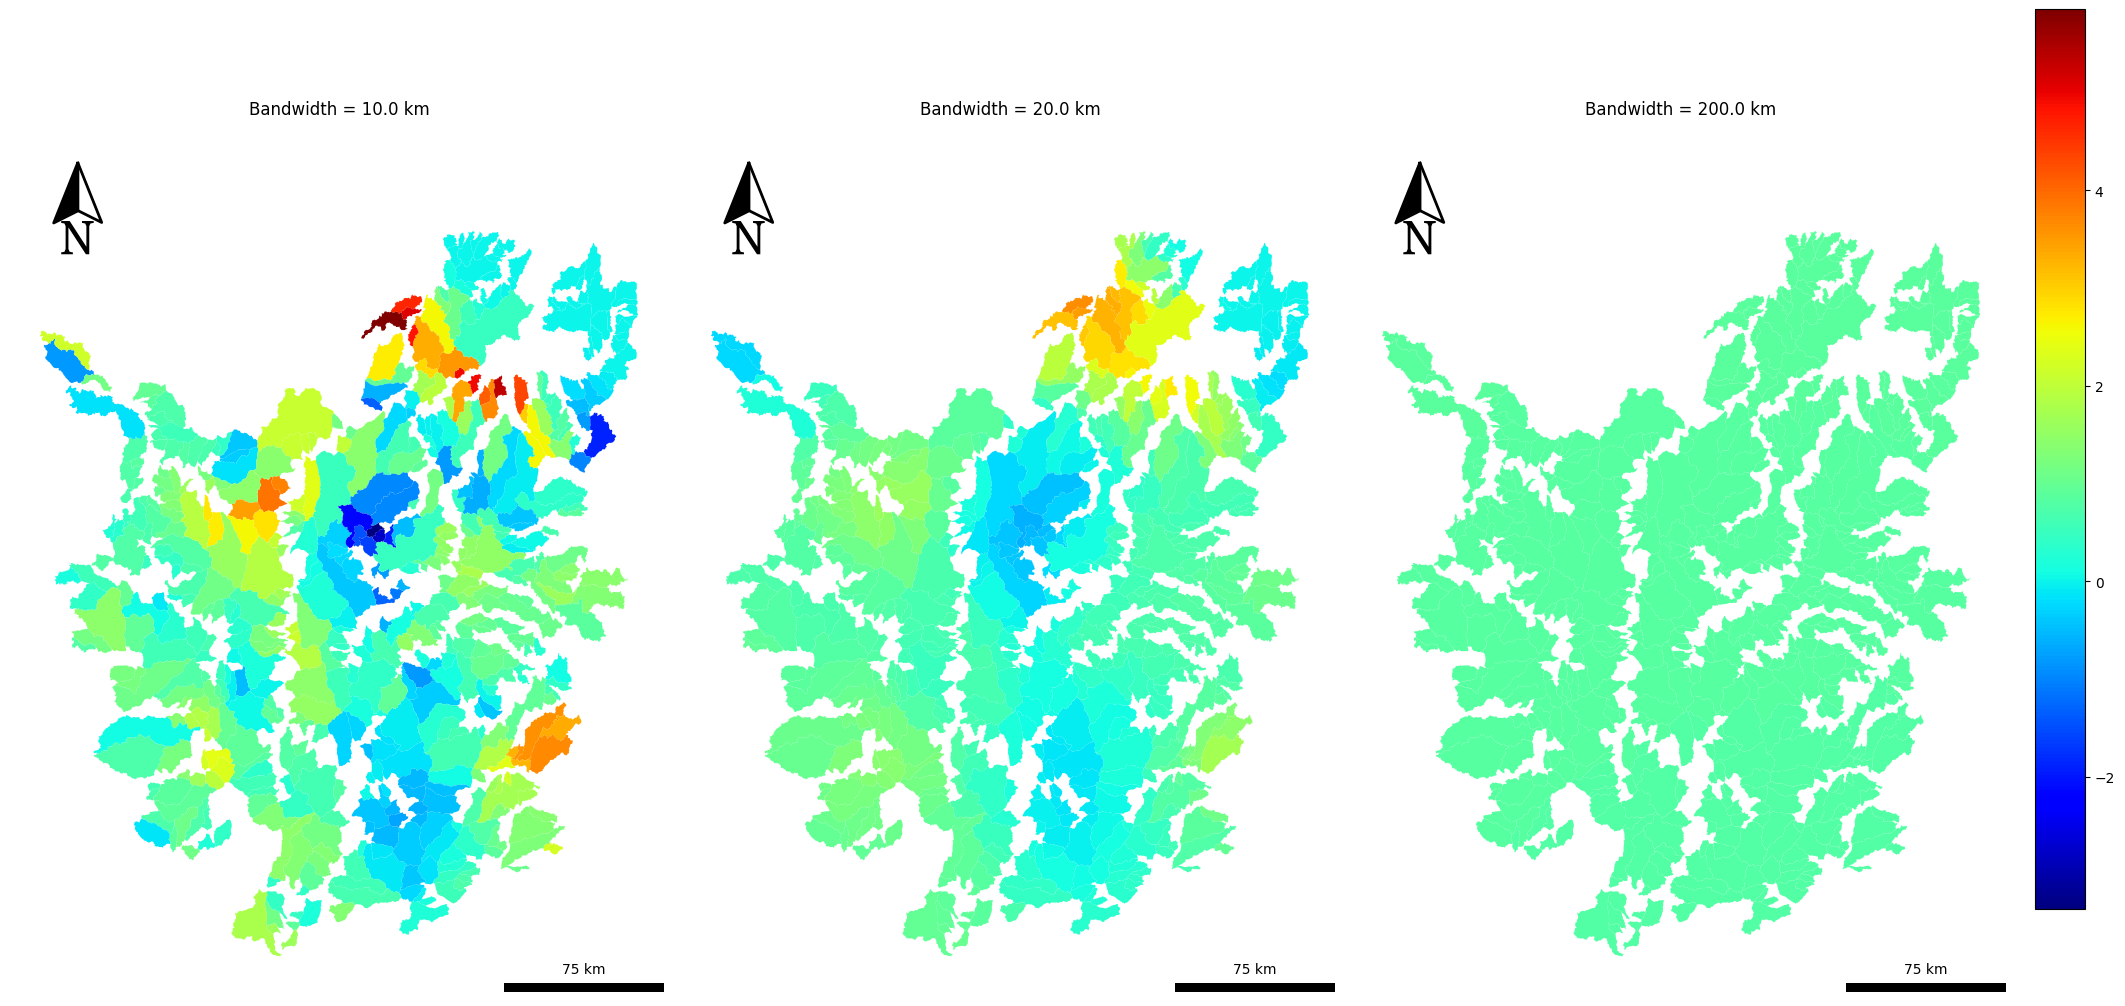

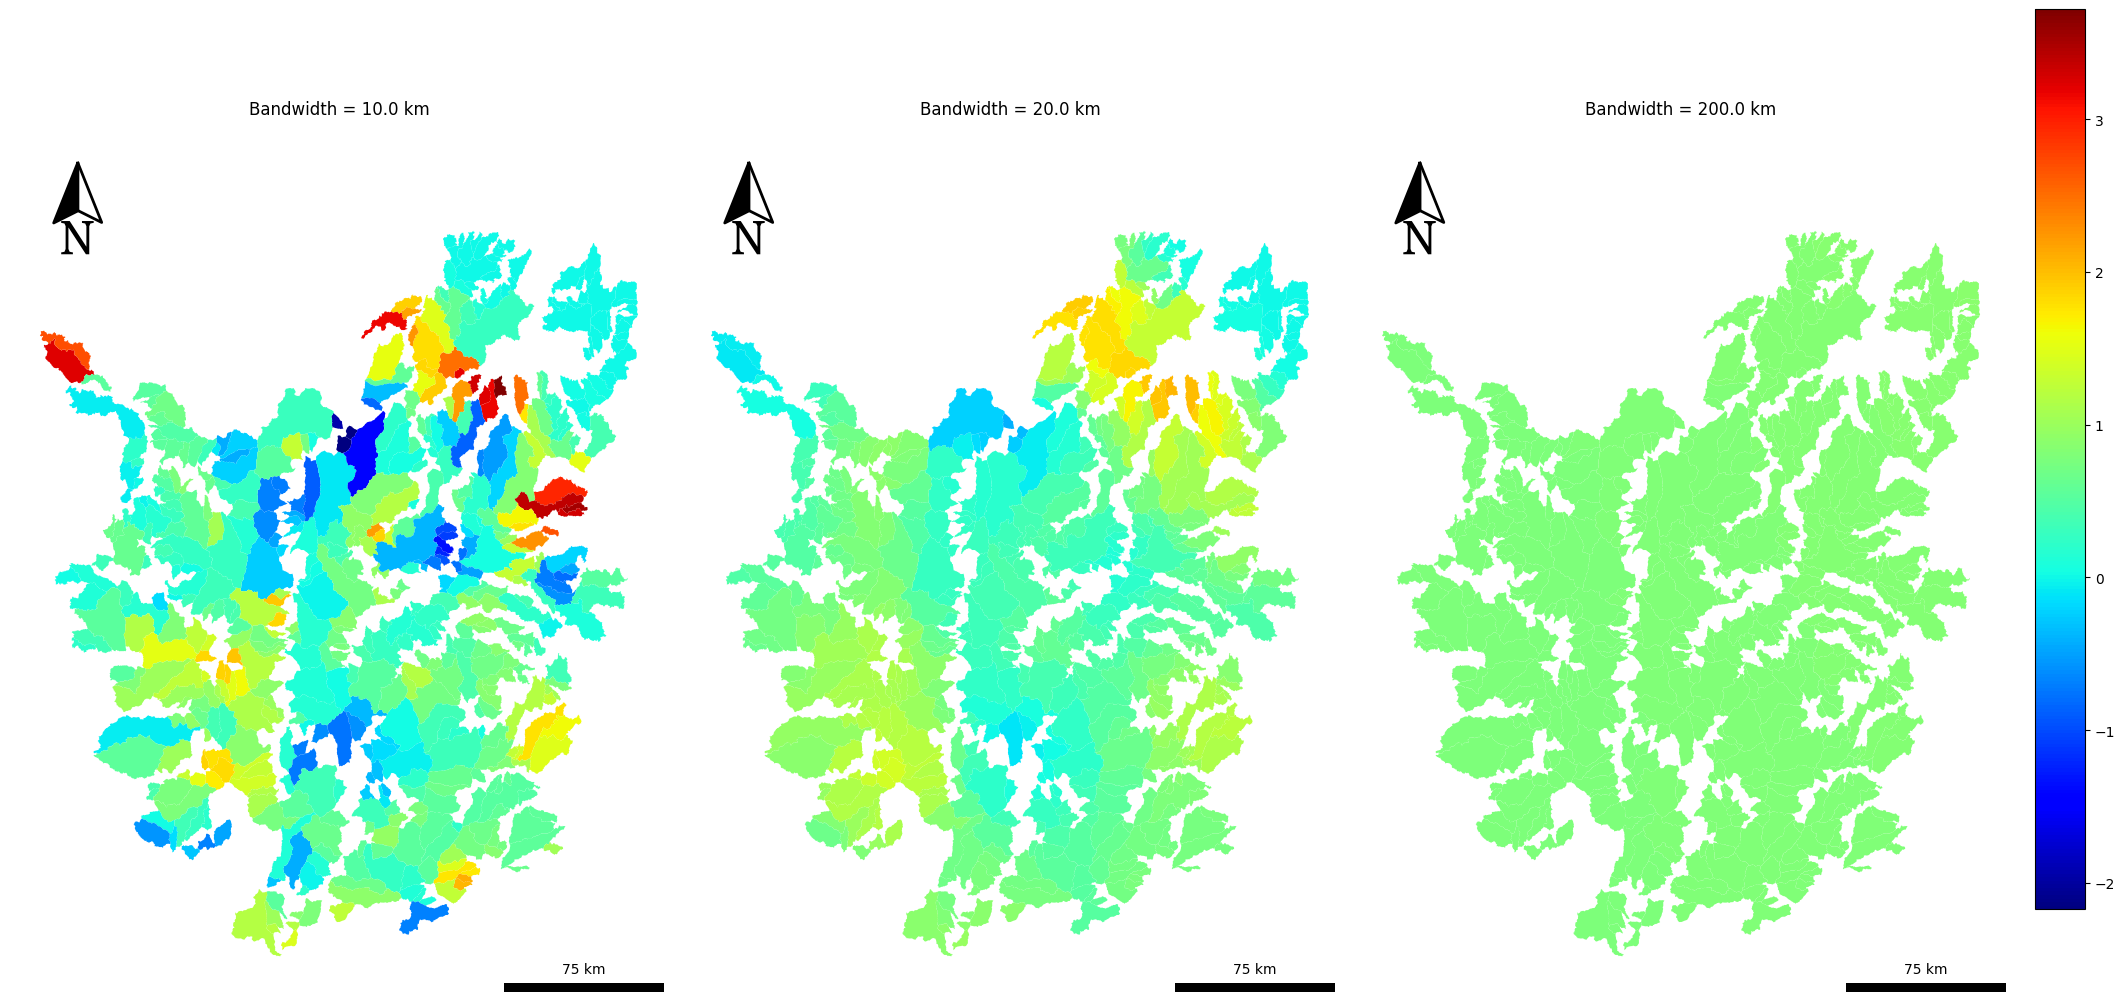

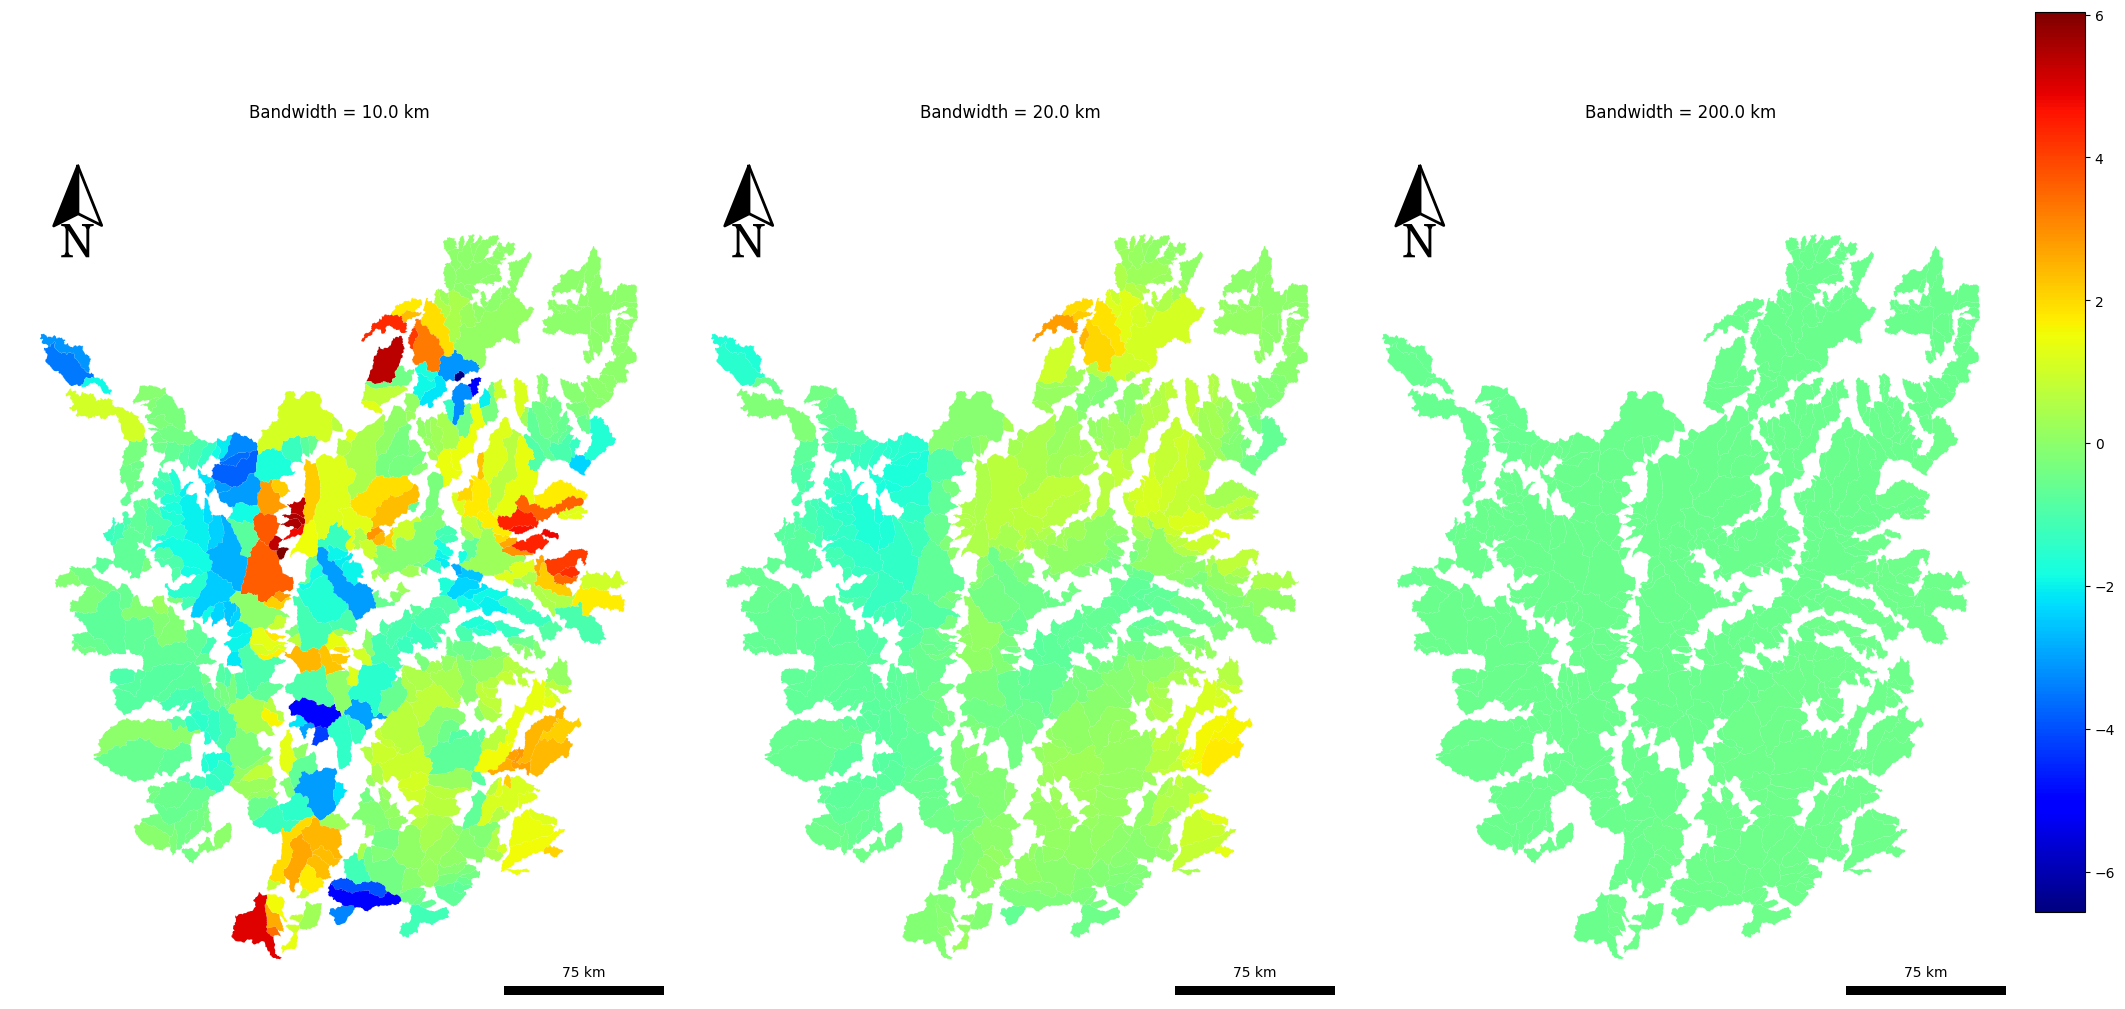

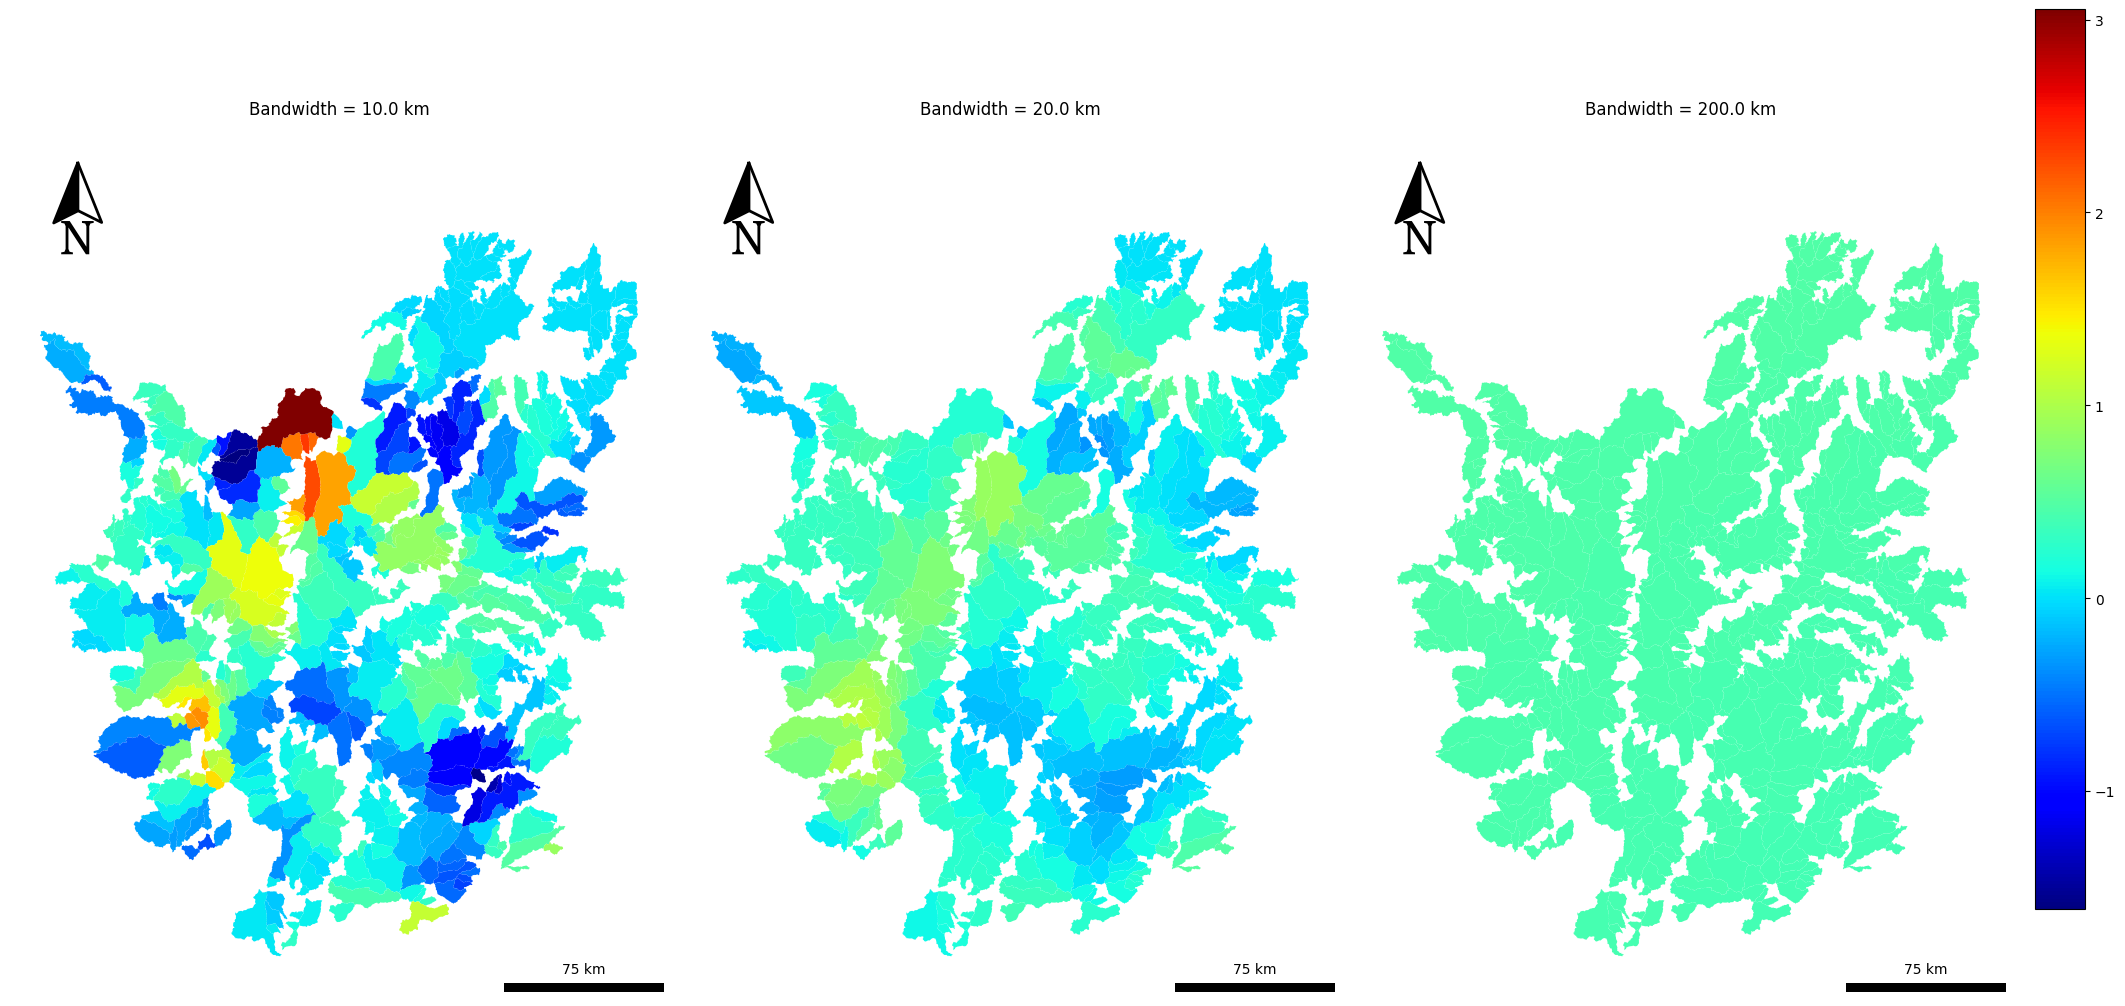

In [11]:
# Loop through each parameter to plot results
variables = ['elev_mean', 'rel_mean', "rainfallAnnual_mean", 'hypso_inte']
diagnostic_data = []

for param_name in variables:
    g_X_num = scaler.fit_transform(gdf[[param_name]])
    bandwidths = [10000, 20000, 200000]
    
    # Determine the global min and max values for the color bar range across all bandwidths
    global_min = float('inf')
    global_max = float('-inf')
    
    # Loop to determine global min and max for colorbar
    for bw in bandwidths:
        # Fit GWR model using the current bandwidth
        model = GWR(g_coords, g_y, g_X_num, bw, kernel='gaussian', fixed=True).fit()
        
        # Extract diagnostic information
        log_likelihood = model.llf
        AIC = model.aic
        adjusted_R2 = model.adj_R2
        
        # Append diagnostic information to list
        diagnostic_data.append([param_name, bw, log_likelihood, AIC, adjusted_R2])
        
        # Extract the local coefficients for the specified covariate
        local_params = model.params[:, 1]  # Index 1 for the current covariate (skipping intercept)
        
        # Update global min and max
        global_min = min(global_min, local_params.min())
        global_max = max(global_max, local_params.max())
    
    # Initialize the figure for the variable
    fig, axes = plt.subplots(1, 3, figsize=(25, 10))
    
    # Loop over each bandwidth, fit the model, and add subplots to the figure
    for j, bw in enumerate(bandwidths):
        # Fit GWR model using the current bandwidth
        model = GWR(g_coords, g_y, g_X_num, bw, kernel='gaussian', fixed=True).fit()
    
        # Extract the local coefficients for the specified covariate
        local_params = model.params
    
        # Extract the corresponding axis for the current bandwidth
        ax = axes[j]
    
        # Update the GeoDataFrame with the new coefficients
        gdf[f'coef_{param_name}_bw_{bw}'] = local_params[:, 1]  # Index 1 (skipping intercept)
        gdf_to_plot = gdf.to_crs(epsg=4326)  # Transform geometries to WGS84 (EPSG:4326) before plotting
    
        # Plot the coefficients on the axis with a fixed color range
        plot = gdf_to_plot.plot(column=f'coef_{param_name}_bw_{bw}', ax=ax, cmap=plt.cm.jet, 
                                legend=False, vmin=global_min, vmax=global_max)
    
        # Customize the subplot
        ax.set_title(f'Bandwidth = {bw / 1000} km', fontsize=12)
        ax.axis('off')
        scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
        add_north_arrow(ax, scale=.75, xlim_pos=.1025, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
        ax.add_artist(scalebar)
    
    # Create a color bar outside the plot
    cax = fig.add_axes([0.86, 0.15, 0.02, 0.9])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=global_min, vmax=global_max))
    fig.colorbar(sm, cax=cax)
    
    # Adjust the layout manually to reduce space between plots
    plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.02)  # Reduced right to leave space for the color bar

# Create DataFrame for diagnostic information
diagnostic_df = pd.DataFrame(diagnostic_data, columns=[
    'Variable', 'Bandwidth', 'Log-Likelihood', 'AIC', 'Adjusted R2'])

# Rename variables for LaTeX table
diagnostic_df['Variable'] = diagnostic_df['Variable'].replace({
    'elev_mean': 'Elevación',
    'rel_mean': 'Relieve',
    'rainfallAnnual_mean': 'Lluvia',
    'hypso_inte': 'Curva Hipso.'
})

# Sort DataFrame by Bandwidth
diagnostic_df = diagnostic_df.sort_values(by='Bandwidth')

# Convert the DataFrame into a LaTeX table
latex_table = diagnostic_df.to_latex(index=False, float_format="%.3f", caption="Comparación de Resultados Diagnósticos para Modelos de Regresión Geográficamente Ponderada (GWR)", label="tab:comparison_results")

# Print the LaTeX table
print(latex_table)


## Modelo completo (vecinos)

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            807.567
Log-likelihood:                                                    -859.116
AIC:                                                               1726.232
AICc:                                                              1728.348
BIC:                                                              -2462.921
R2:                                                                   0.374
Adj. R2:                                                              0.371

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

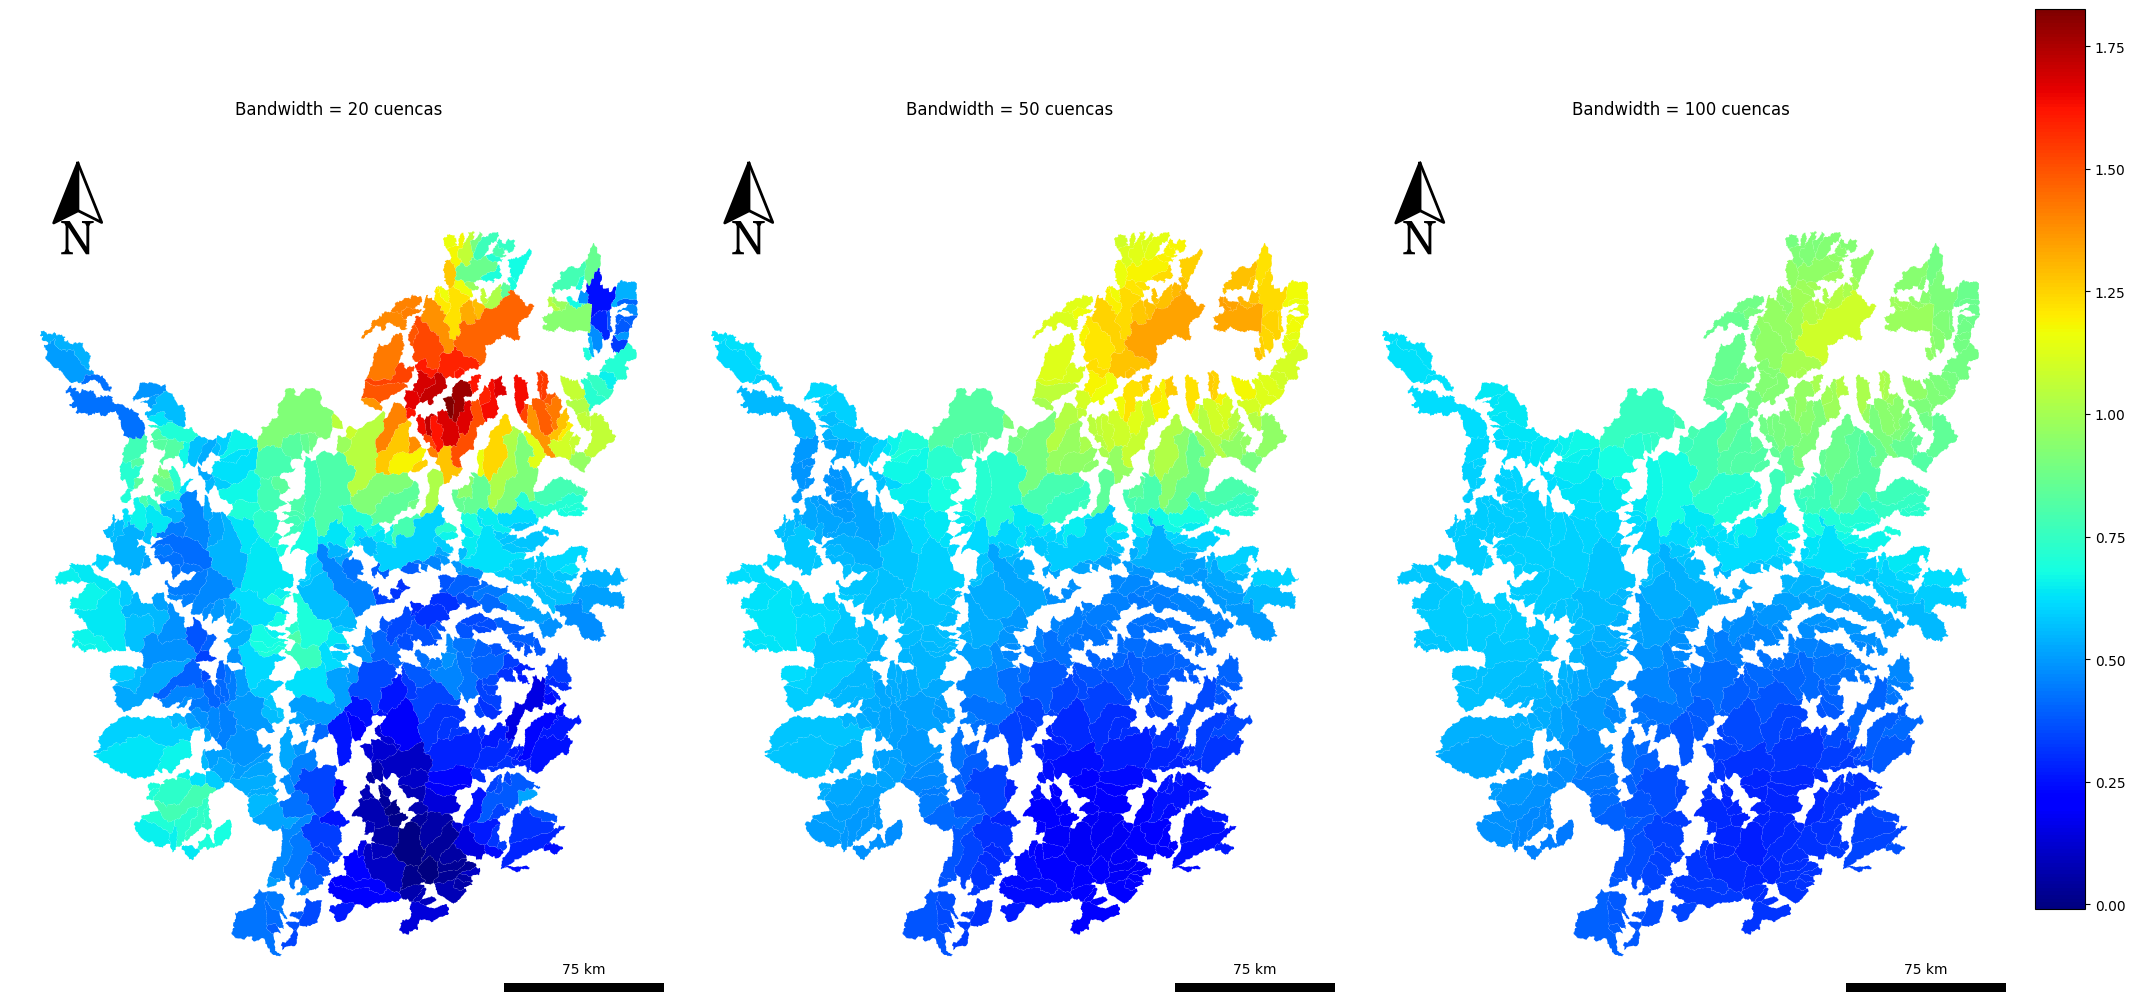

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            807.567
Log-likelihood:                                                    -859.116
AIC:                                                               1726.232
AICc:                                                              1728.348
BIC:                                                              -2462.921
R2:                                                                   0.374
Adj. R2:                                                              0.371

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

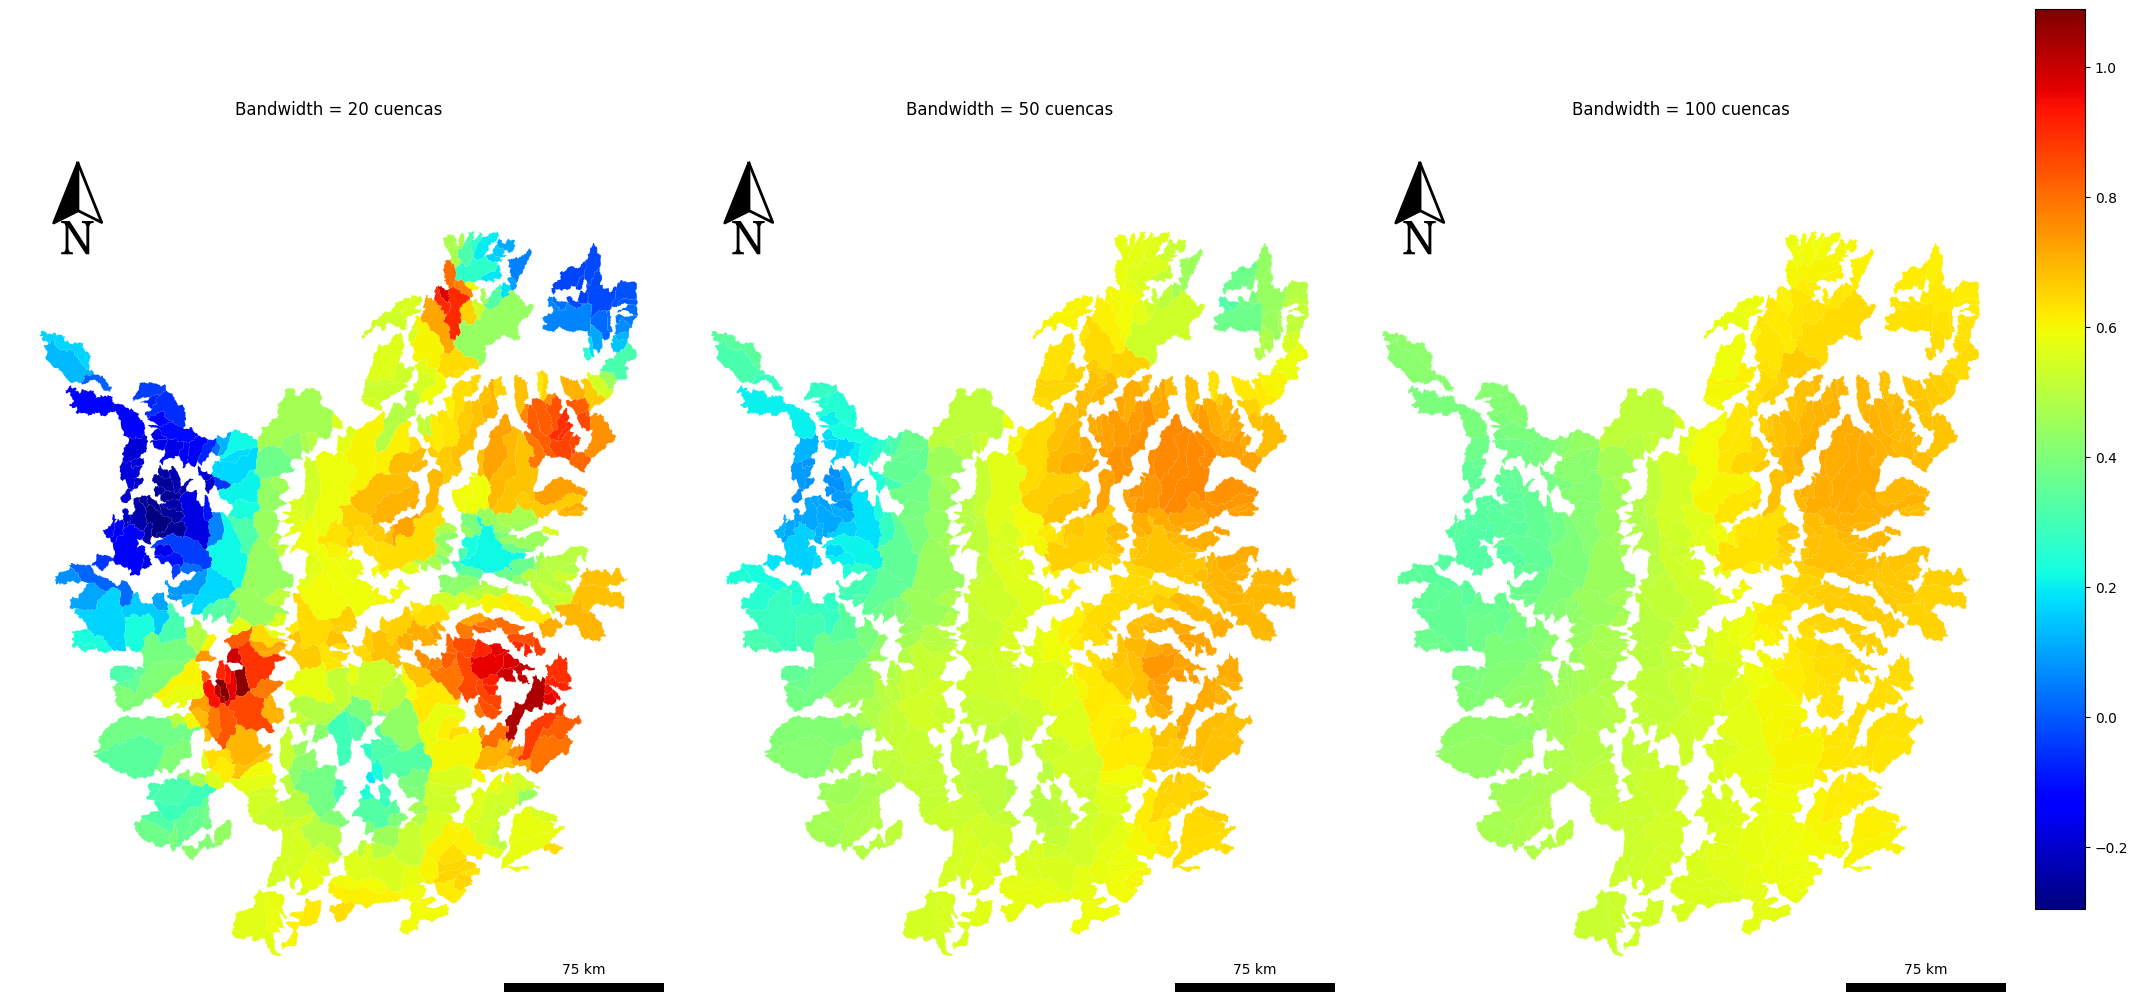

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            807.567
Log-likelihood:                                                    -859.116
AIC:                                                               1726.232
AICc:                                                              1728.348
BIC:                                                              -2462.921
R2:                                                                   0.374
Adj. R2:                                                              0.371

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

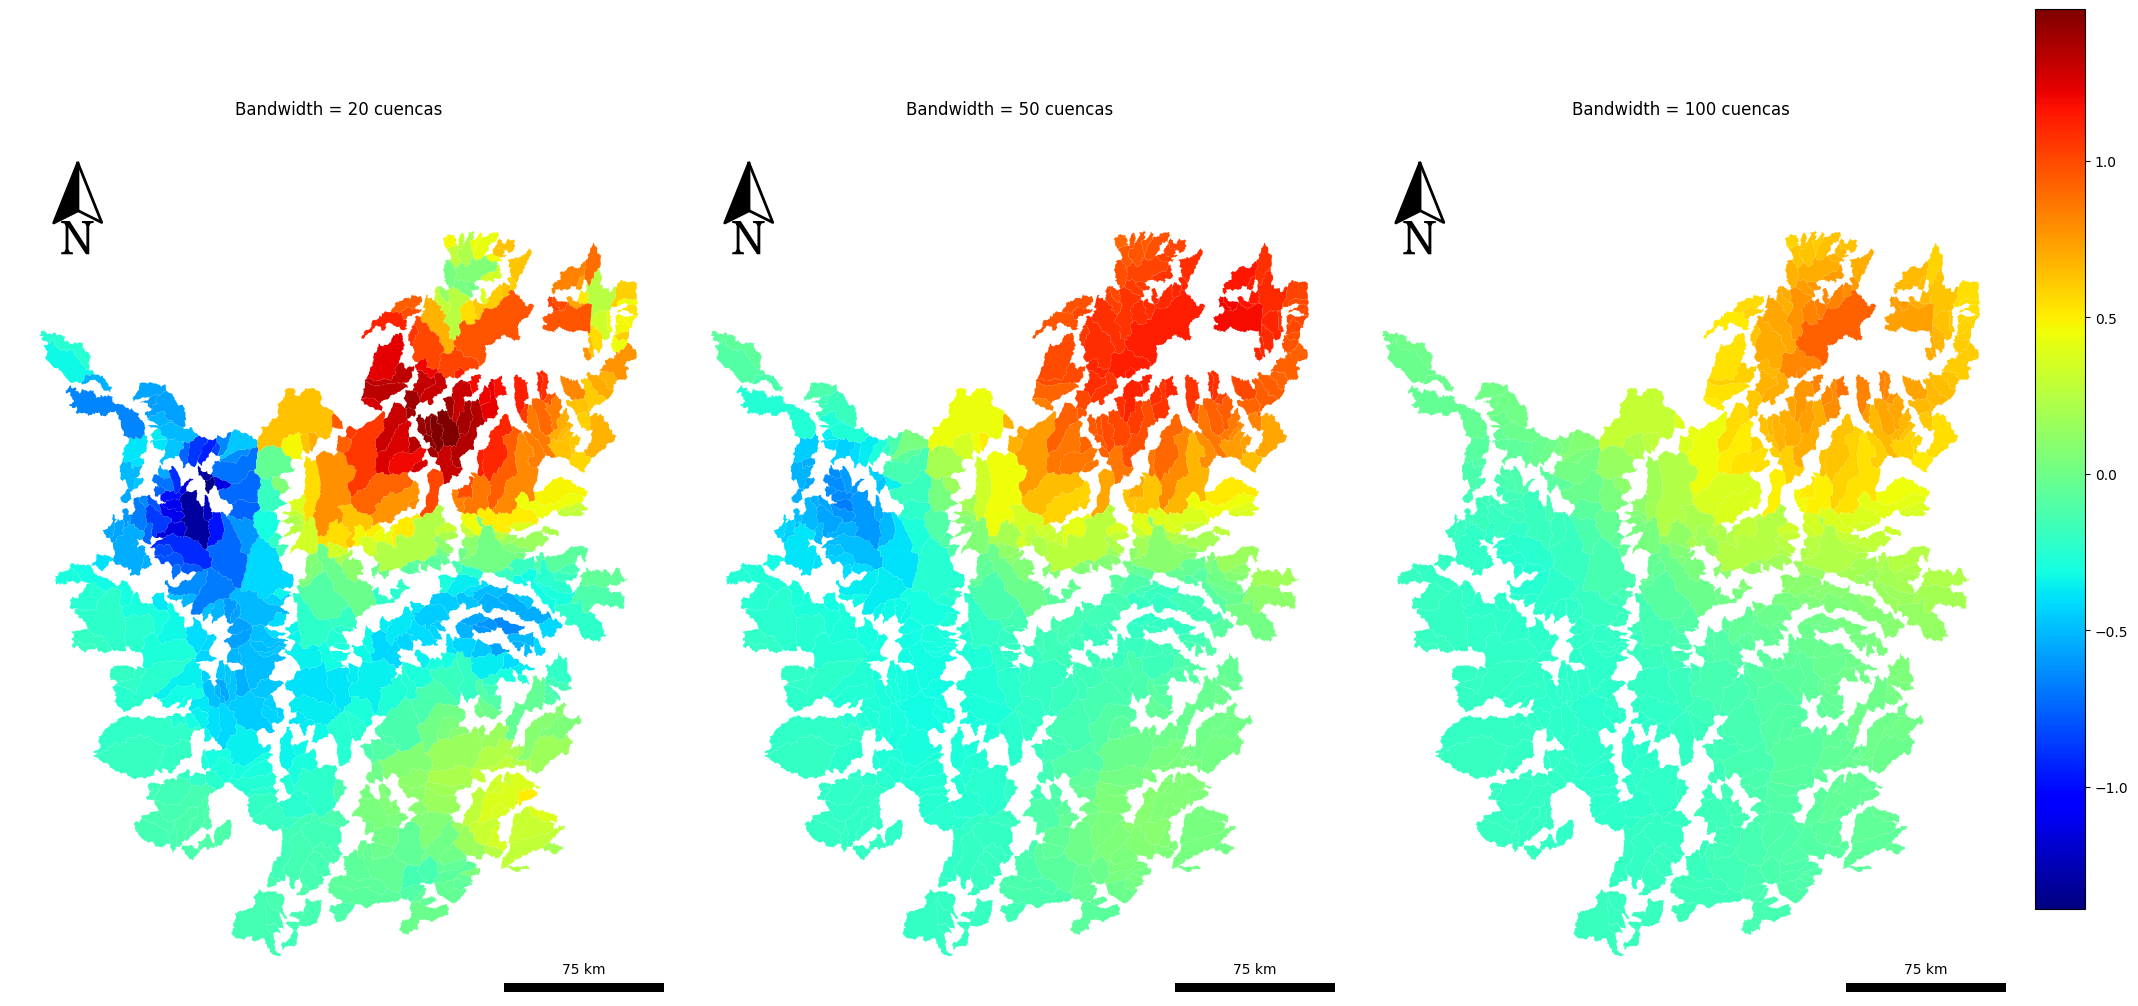

In [14]:
variables = ['elev_mean', 'rel_mean',"rainfallAnnual_mean"]
n = 0
for param_name in variables:
    n+=1
    # Standardize continuous variables
    scaler = StandardScaler()
    g_X_num = scaler.fit_transform(gdf[variables])
    
    # List of bandwidths to iterate over
    bandwidths = [20, 50, 100]
    
    # Determine the global min and max values for the color bar range across all bandwidths
    global_min = float('inf')
    global_max = float('-inf')
    
    # Loop to determine global min and max for colorbar
    for bw in bandwidths:
        # Fit GWR model using the current bandwidth
        model = GWR(g_coords, g_y, g_X_num, bw, kernel='gaussian').fit()
        model.summary()
    
        # Extract the local coefficients for the specified covariate
        local_params = model.params[:, n]  # Index 1 for 'elev_mean' (skipping intercept)
        
        # Update global min and max
        global_min = min(global_min, local_params.min())
        global_max = max(global_max, local_params.max())
    
    # Initialize the figure for the variable
    fig, axes = plt.subplots(1, 3, figsize=(25, 10))
    
    # Loop over each bandwidth, fit the model, and add subplots to the figure
    for j, bw in enumerate(bandwidths):
        # Fit GWR model using the current bandwidth
        fullmodel_elev = GWR(g_coords, g_y, g_X_num, bw, kernel='gaussian').fit()
    
        # Extract the local coefficients for the specified covariate
        local_params = fullmodel_elev.params
    
        # Extract the corresponding axis for the current bandwidth
        ax = axes[j]
    
        # Update the GeoDataFrame with the new coefficients
        gdf[f'coef_{param_name}_bw_{bw}'] = local_params[:, n]  # Index 1 for 'elevation' (skipping intercept)
        gdf_to_plot = gdf.to_crs(epsg=4326)  # Transform geometries to WGS84 (EPSG:4326) before plotting
    
        # Plot the coefficients on the axis with a fixed color range
        plot = gdf_to_plot.plot(column=f'coef_{param_name}_bw_{bw}', ax=ax, cmap=plt.cm.jet, 
                                legend=False, vmin=global_min, vmax=global_max)
    
        # Customize the subplot
        ax.set_title(f'Bandwidth = {bw} cuencas', fontsize=12)
        ax.axis('off')
        scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
        add_north_arrow(ax, scale=.75, xlim_pos=.1025, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
        ax.add_artist(scalebar)
    
    # Create a color bar outside the plot
    cax = fig.add_axes([0.86, 0.15, 0.02, 0.9])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=global_min, vmax=global_max))
    fig.colorbar(sm, cax=cax)
    
    # Adjust the layout manually to reduce space between plots
    plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.02)  # Reduced right to leave space for the color bar
    
    # Save the figure after iterating through all bandwidths for the specified parameter
    plt.savefig(f"G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_MGWR/FIGURAS/modelo_{param_name}_coefficients.png", dpi=500)
    plt.show()

## Tabla comparacion modelo

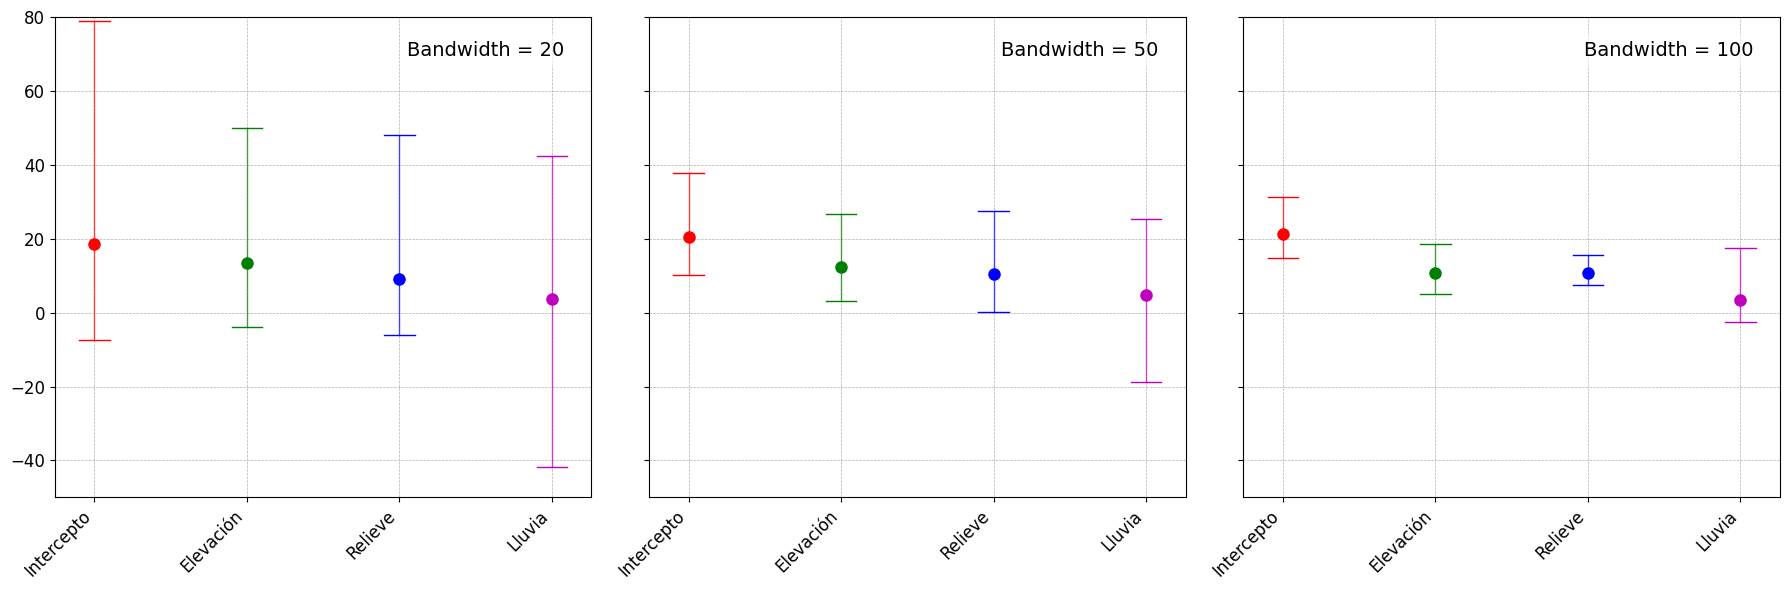

In [353]:
# Create a figure with 1 row and 3 columns for the bandwidths
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bandwidth values
bandwidths = [20, 50, 100]

# Updated summary statistics for each bandwidth based on provided results
summary_stats = {
    20: {
        'Intercepto': {'mean': 18.568, 'min': -7.362, 'max': 78.791},
        'Elevación': {'mean': 13.337, 'min': -3.761, 'max': 49.873},
        'Relieve': {'mean': 9.181, 'min': -6.014, 'max': 47.960},
        'Lluvia': {'mean': 3.568, 'min': -41.829, 'max': 42.474}
    },
    50: {
        'Intercepto': {'mean': 20.590, 'min': 10.083, 'max': 37.719},
        'Elevación': {'mean': 12.207, 'min': 3.121, 'max': 26.553},
        'Relieve': {'mean': 10.360, 'min': 0.192, 'max': 27.626},
        'Lluvia': {'mean': 4.632, 'min': -18.773, 'max': 25.238}
    },
    100: {
        'Intercepto': {'mean': 21.152, 'min': 14.859, 'max': 31.180},
        'Elevación': {'mean': 10.738, 'min': 5.020, 'max': 18.674},
        'Relieve': {'mean': 10.839, 'min': 7.595, 'max': 15.603},
        'Lluvia': {'mean': 3.462, 'min': -2.474, 'max': 17.576}
    }
}

# Variable labels
variables = ['Intercepto', 'Elevación', 'Relieve', 'Lluvia']
colors = ['r', 'g', 'b', 'm']  # Colors for each variable

# Loop over each bandwidth to create a plot
for j, bw in enumerate(bandwidths):
    ax = axes[j]
    
    means_vals = []
    mins_vals = []
    maxs_vals = []
    
    # Extract statistics for the current bandwidth
    for var in variables:
        means_vals.append(summary_stats[bw][var]['mean'])
        mins_vals.append(summary_stats[bw][var]['min'])
        maxs_vals.append(summary_stats[bw][var]['max'])

    # Create x-values for the variables
    x_vals = np.arange(len(variables))
    
    # Plot the mean values as points
    for i, (x, mean, color) in enumerate(zip(x_vals, means_vals, colors)):
        ax.plot(x, mean, 'o', color=color, markersize=8)
        
        # Plot the min and max values as lines with matching color
        ax.plot([x, x], [mins_vals[i], maxs_vals[i]], '-', color=color, alpha=0.7, linewidth=1)
        
        # Add small horizontal caps at the ends of the lines
        cap_width = 0.1
        ax.plot([x - cap_width, x + cap_width], [mins_vals[i], mins_vals[i]], '-', color=color, linewidth=1)
        ax.plot([x - cap_width, x + cap_width], [maxs_vals[i], maxs_vals[i]], '-', color=color, linewidth=1)

    # Set x-ticks and labels with increased size
    ax.set_xticks(x_vals)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12)  # Increased font size by 50%
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Set y-axis limits
    ax.set_ylim(-50, 80)  # Adjusted y-axis limit to accommodate new data range
    
    # Set y-tick label size and remove y-axis tick labels for the second and third subplots
    if j > 0:
        ax.tick_params(axis='y', labelleft=False)
    else:
        ax.tick_params(axis='y', labelsize=12)  # Increased font size by 50%
    
    # Remove x-axis labels for all subplots
    ax.set_xlabel('')
    
    # Add the bandwidth label in the upper right corner
    ax.text(0.95, 0.95, f'Bandwidth = {bw}', horizontalalignment='right', verticalalignment='top', 
            transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Adjust layout
plt.tight_layout()
plt.savefig("G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_MGWR/FIGURAS/model_summary.png", dpi=500)
plt.show()



In [14]:
# Select optimal bandwidth for GWR model using coordinates, response, and predictors
variables = ['elev_mean', 'rel_mean',"rainfallAnnual_mean"]
g_X_num = scaler.fit_transform(gdf[variables])
gwr_selector = Sel_BW(g_coords, g_y, g_X_num, multi=True)
selector = gwr_selector.search()
print(selector)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 44.  92. 522. 524.]


In [15]:
# Fit the MGWR model using the selected bandwidths
model = MGWR(g_coords, g_y, g_X_num, gwr_selector).fit()
model.summary()

# Extract optimal bandwidths from the model
optimal_bandwidths = selector

# Define variable names (replace with actual variable names)
variable_names = ["Intercepto", "Elevación", "Relieve", "Lluvia"]  # Adjust as per your data
variable_names = variable_names[:len(optimal_bandwidths)]  # Ensure it matches the number of variables

# Create a list to store table data
table_data = []

# Collect metrics for each variable
for i, var_name in enumerate(variable_names):
    optimal_bandwidth = optimal_bandwidths[i]
    coefficient_mean = model.params[:, i].mean()  # Mean of coefficients for each variable 
    coefficient_min = model.params[:, i].min()  # Minimum value of coefficients for each variable
    coefficient_max = model.params[:, i].max()  # Maximum value of coefficients for each variable
    standard_error_mean = model.bse[:, i].mean()  # Mean of standard errors for each variable

    # Add data to the table
    table_data.append({
        "Variables": var_name,
        "BW": optimal_bandwidth,
        "Coeficiente medio": coefficient_mean,
        "Coef. Min.": coefficient_min,
        "Coef. Max.": coefficient_max,
        "STD": standard_error_mean
    })

# Adding overall MGWR model statistics as separate rows
table_data.append({
    "Variables": "Log-Likelihood",
    "BW": model.llf,  # MGWR-specific log-likelihood
    "Coeficiente medio": "",
    "Coef. Min.": "",
    "Coef. Max.": "",
    "STD": ""
})
table_data.append({
    "Variables": "AIC",
    "BW": model.aic,  # MGWR-specific AIC
    "Coeficiente medio": "",
    "Coef. Min.": "",
    "Coef. Max.": "",
    "STD": ""
})
table_data.append({
    "Variables": "Adjusted R²",
    "BW": model.adj_R2,  # MGWR-specific Adjusted R²
    "Coeficiente medio": "",
    "Coef. Min.": "",
    "Coef. Max.": "",
    "STD": ""
})

# Convert the data to a DataFrame
df = pd.DataFrame(table_data)

# Convert the DataFrame to a LaTeX table with no vertical lines and custom column names
latex_table = df.to_latex(index=False, column_format="lcccccc", float_format="%.3f", header=["Variables", "BW", "Coeficiente medio", "Coef. Min.", "Coef. Max.", "STD"]).replace('|', '')
print(latex_table)

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 526
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            807.013
Log-likelihood:                                                    -858.936
AIC:                                                               1725.872
AICc:                                                              1727.987
BIC:                                                              -2463.474
R2:                                                                   0.375
Adj. R2:                                                              0.371

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

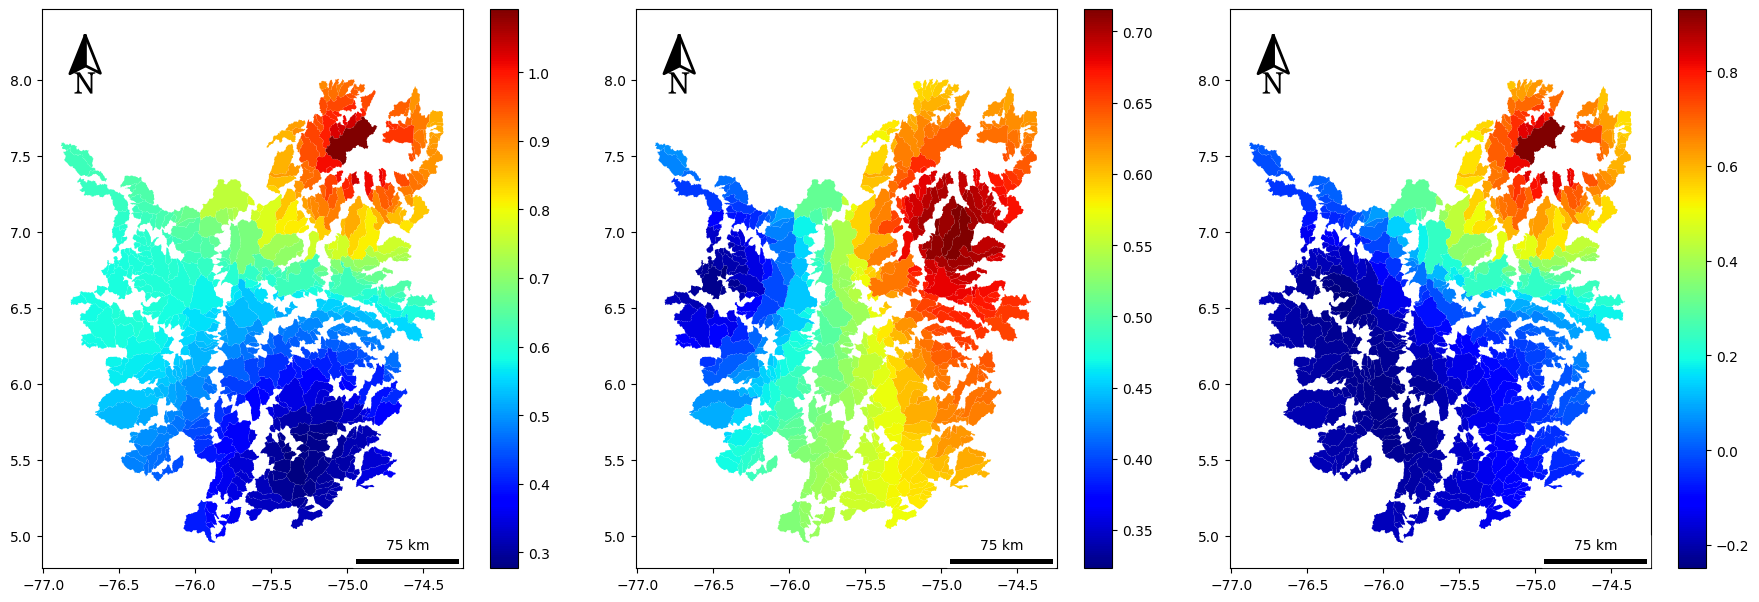

In [16]:
# Extract and plot the local coefficients for each covariate
local_params = model.params

# Create a single plot with three columns for each covariate (elevation, relief, and rainfall)
param_names = ['elev_mean', 'rel_mean', 'rainfallAnnual_mean']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Transform geometries to WGS84 (EPSG:4326) before plotting
data_clean = gdf.to_crs(epsg=4326)

for i, param_name in enumerate(param_names):
    ax = axes[i]
    data_clean[f'coef_{param_name}'] = local_params[:, i+1] #tengo +1 para qeu no considere el primer coeficiente que pertenece al intercepto
    data_clean.plot(column=f'coef_{param_name}', ax=ax, cmap=plt.cm.jet, legend=True)
    add_north_arrow(ax, scale=.75, xlim_pos=.1025, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
    scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
    ax.add_artist(scalebar)
    
# Save the entire figure with all three subplots
plt.tight_layout()
plt.savefig("G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_MGWR/FIGURAS/modelo_best.png", dpi=500)
plt.show()

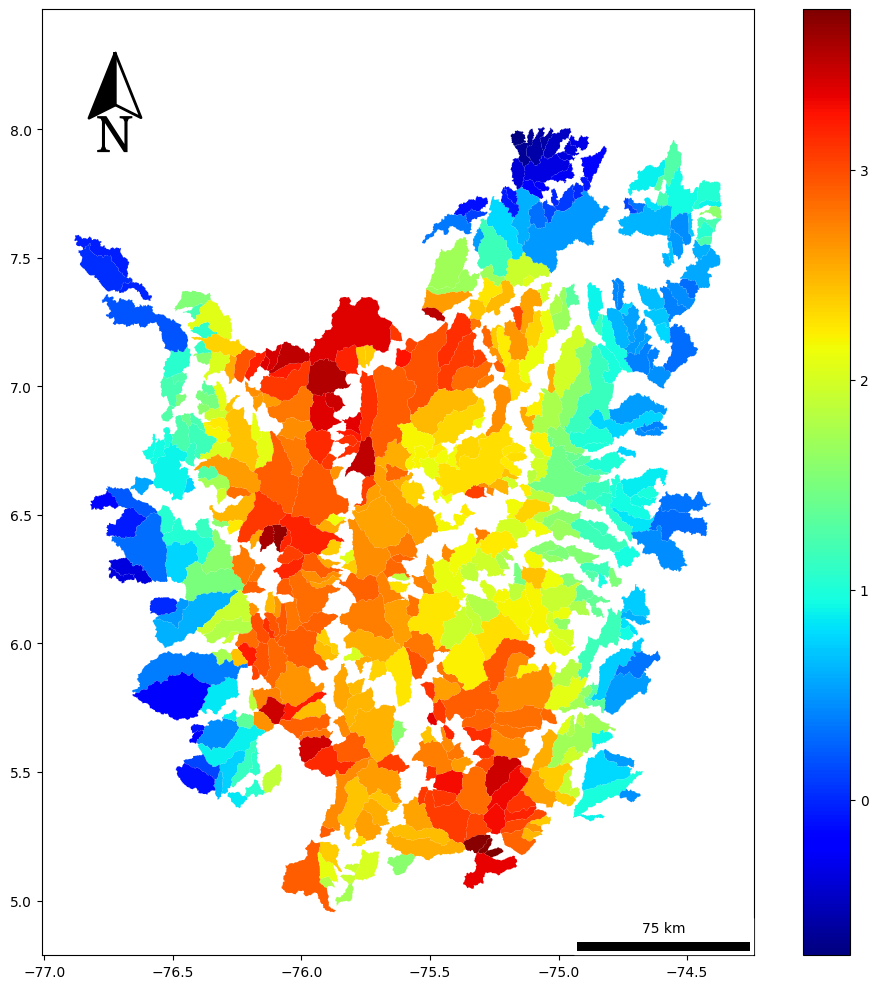

In [17]:
# Assuming model is the fitted MGWR model object
fig, ax = plt.subplots(figsize=(10, 10))
data_clean["fitted"] = model.predy  # The predicted values (fitted values) from the MGWR model
data_clean.plot(column="fitted", ax=ax, cmap=plt.cm.jet, legend=True)
add_north_arrow(ax, scale=.75, xlim_pos=.1025, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
ax.add_artist(scalebar)
plt.tight_layout()
plt.savefig("G:/My Drive/INVESTIGACION/PAPERS/ELABORACION/Modelo_MGWR/FIGURAS/map_best.png", dpi=500)
plt.show()